##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [60]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
import Dense as Dense
importlib.reload(LSTM)
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
# pool.close()

In [61]:
FillVar = 'fco2'

FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD','Temp','VWC','Sedge','Shrub','Out_of_Basin']
print(len(FullModel))
Runs,params = Dense.Params('Test',FillVar,MP=False)# rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
Runs['CI'] = 0.0
print(Runs)
params['epochs'] = 20
params['reps'] = 3
print(params)

11
     N  MSE  STD   CI
0   50  0.0  0.0  0.0
1  100  0.0  0.0  0.0
{'proc': 1, 'N_Max': 100, 'N_Min': 50, 'reps': 3, 'epochs': 20, 'Y': 'fco2', 'Searches': 2}


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finisehed Run  0  MSE:  0.130950771948
Finisehed Run  1  MSE:  0.114584828561
99.7115592956543


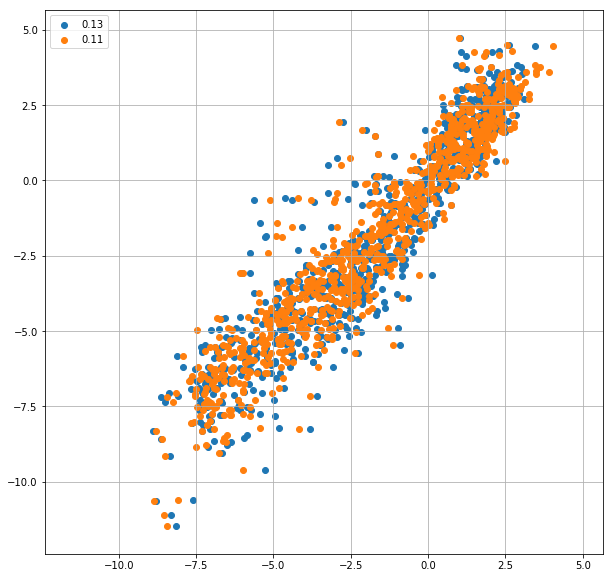

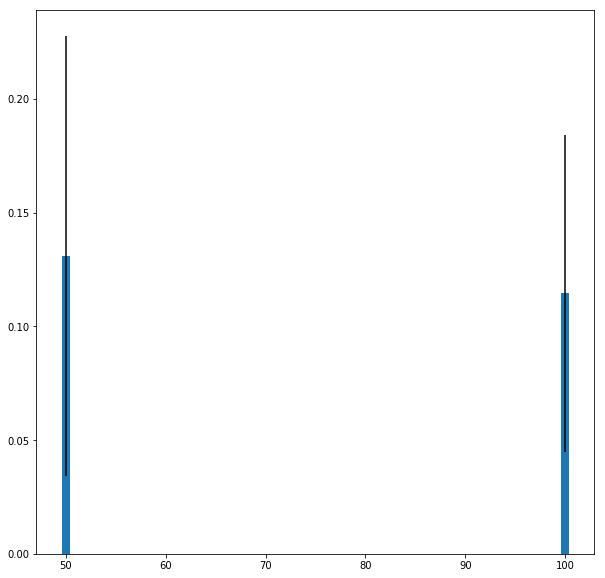

In [62]:

def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Dense.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))




Time = time.time()
Path = 'Data_Footprints_2018-05-10.csv'

plt.figure(figsize=(10,10))
def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
#     STD = []
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['reps']))):
#             mse = results[0]
#             y_fill = results[1]
            MSE.append(results[0])
            Y_fill.append(results[1])
            Yval.append(results[2])
            y_val.append(results[3])
#             Y_fill.append(y_fill)
#             MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Yval.append(results[2])
            y_val.append(results[3])
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    
    Yval = np.asanyarray(Yval)
    Yval = Yval.mean(axis=0)
    y_val = np.asanyarray(y_val)
    y_val = y_val.mean(axis=0)
    
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
    if plot == True:
        
#         plt.scatter(y_val,Yval,label=np.round(MSE.mean(),2))
        plt.scatter(RST.Master['TempFill'],RST.Master[FillVar],label=np.round(MSE.mean(),2))
        yl = plt.ylim()
        plt.xlim(yl)
        
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    try:
        params['T']=Runs['T'].iloc[i]
    except:
        params['T'] = 0
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool,plot=True)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i),' MSE: ',MSE.mean())

plt.grid()
plt.legend()
Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-2)
try:
    plt.figure(figsize=(10,10))
    plt.scatter(Runs['N'],Runs['T'],c = Runs['MSE'],s=Runs['STD']*1e4)
except:
    plt.figure(figsize=(10,10))
    plt.bar(Runs['N'],Runs['MSE'],yerr=Runs['CI'])
    
    
## - 400 reps
# Finisehed Run  0  MSE:  0.148056887042
# Finisehed Run  1  MSE:  0.111017386762
# Finisehed Run  2  MSE:  0.106611905347
# Finisehed Run  3  MSE:  0.0990521019495

# Out of the box
# Finisehed Run  0  MSE:  0.0855806333132
# Finisehed Run  1  MSE:  0.08350419992
# 47.759695053100586


print(time.time()-Time)
# 137.56657123565674,864.5321040153503

# 134.01855874061584

In [63]:
def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x


# kernel = Matern()#length_scale = [1,1],length_scale_bounds="fixed")
# kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
# + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf
    for N in np.linspace(1,params['N_Max']):
        if params['T']>0:
            for T in np.linspace(0,params['T_Max']):
                def obj(x):
                    x=x.reshape(1,-1)
                    mu_x, sigma_x = gp.predict(x, return_std=True)
                    return acq(mu_x, sigma_x, np.min(yi))
                x0 = np.asanyarray([N,T]).reshape(1,2)
                bounds=((1, params['N_Max']),(0,params['T_Max']))
                print(x0,bounds)
                res = minimize(obj, x0, bounds=bounds)

                if res.fun < best_value:
                    best_value = res.fun
                    query_point = res.x
        else:
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray(N).reshape(1,-1)
            bounds=[(1, params['N_Max'])]
            res = minimize(obj, x0, bounds=bounds)
            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point


params['T']=0
for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    if params['T']>0:
        gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
        next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
        N = int(np.round(next_x[0],0))
        T = int(np.round(next_x[1],0))
        o = 0
        while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
            print('Adjust!')
            o +=1
            N += int(o*np.cos(o*np.pi))
            if N < params['N_Min'] or N > params['N_Max']:
                N -= int(o*np.cos(o*np.pi))
            if o > 5:
                T += 1
        print(N,T)
        d = {'N':N,'T':T,'MSE':0,'STD':0}
        idx = Runs.index[-1] + 1
        D2 = pd.DataFrame(data=d,index=[idx])
        Runs = Runs.append(D2)
        params['T'] = T
        params['N'] = N
        Results = RunReps(FullModel,params,pool)
        MSE = Results[0]
        Runs['MSE'][idx]=MSE.mean()
        Runs['STD'][idx]=MSE.std()
        Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    else:
        gp.fit(Runs['N'].values.reshape(-1,1), Runs['MSE'].values)
        next_x = query(Runs['N'].values, Runs['MSE'].values, gp)
        N = int(np.round(next_x[0],0))
        o = 0
        while len(Runs.loc[Runs['N']==N].index) != 0:
            print('Adjust!')
            o +=1
            N += int(o*np.cos(o*np.pi))
            if N < params['N_Min'] or N > params['N_Max']:
                N -= int(o*np.cos(o*np.pi))
        print(N)
        d = {'N':N,'MSE':0,'STD':0}
        idx = Runs.index[-1] + 1
        D2 = pd.DataFrame(data=d,index=[idx])
        Runs = Runs.append(D2)
        params['N'] = N
        Results = RunReps(FullModel,params,pool)
        MSE = Results[0]
        Runs['MSE'][idx]=MSE.mean()
        Runs['STD'][idx]=MSE.std()
        Runs = Runs.sort_values(by = ['N']).reset_index(drop=True)
        

# plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)

96


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


91


         CI       MSE    N       STD  Upper_Bounds
0  0.044719  0.130951   50  0.026526      0.175670
1  0.021494  0.114798   91  0.012750      0.136292
2  0.032052  0.119506   96  0.019012      0.151557
3  0.032217  0.114585  100  0.019110      0.146801
Optimum:
         CI       MSE   N       STD  Upper_Bounds
0  0.044719  0.130951  50  0.026526       0.17567
4
         CI       MSE   N       STD  Upper_Bounds
0  0.044719  0.130951  50  0.026526      0.175670
1  0.021494  0.114798  91  0.012750      0.136292


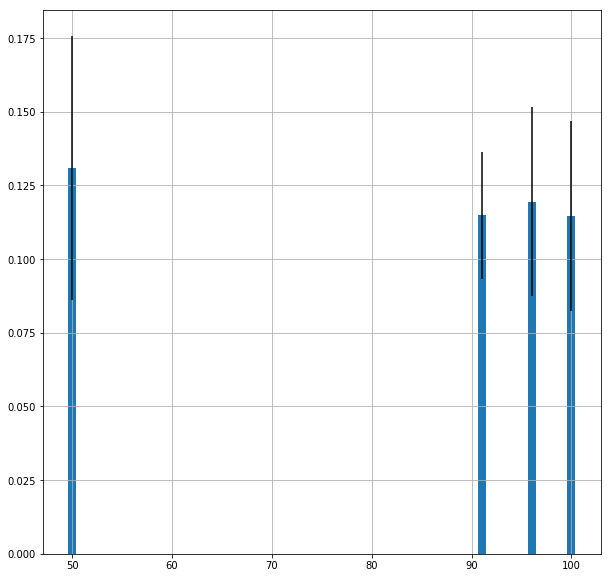

In [79]:
try:
    Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-2)
    Runs['Upper_Bounds'] = Runs['MSE']+Runs['CI']
    plt.figure(figsize=(10,10))
    plt.scatter(Runs['N'],Runs['T'],c = Runs['MSE'],s=Runs['STD']*1e4)
except:
    Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-1)
    Runs['Upper_Bounds'] = Runs['MSE']+Runs['CI']
    plt.figure(figsize=(10,10))
    plt.bar(Runs['N'],Runs['MSE'],yerr=Runs['CI'])
    
plt.grid()
print(Runs)
Optimum = Runs[Runs['MSE'] <= Runs['Upper_Bounds'].min()]
# print(Optimum)
Optimum = Optimum[Optimum['N'] == Optimum['N'].min()]

print('Optimum:')
print(Optimum)


# Feature Identification

In [76]:
BestMSE = []
BestSTD = []
idx = []
BestModels = []

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    print (Models)
    return(Models)
try:
    params['T']=Optimum['T'].values[0]
except:
    pass
params['N']=Optimum['N'].values[0]
# print(Optimum)

Cutoff = 1

print(FullModel)
Scores = Optimum[['MSE','CI','Upper_Bounds','STD']].reset_index(drop=True)
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)
# print(Scores)
Results = RunReps(FullModel,params,pool)
ModelRuns = Results[1]
ModelRuns = ModelRuns.to_frame()
ModelRuns.rename(columns={'TempFill':'+'.join(FullModel)})
# print(ModelRuns)

for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
    
    for i,model in enumerate(Models):
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+'+'.join(model)
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        mean,std = MSE.mean(),MSE.std()
        CI = std/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-1)
        level = len(model)
        key = str(level)+'_'+str(i)
        d = {'Model':'+'.join(model),
             'MSE':mean,'STD':std,'Level':level,
             'CI':CI,'Upper_Bounds':mean+CI,
                'Key':key}
        score = pd.DataFrame(index=[0],data=d)
        print(model,' Upper Bound ',mean+CI)
        Scores = Scores.append(score,ignore_index=True)
        ModelRuns['Model: '+'+'.join(model)] = Results[1]
        
    Level = Scores.loc[Scores['Level'] == level]
    Lowest_Yet = Scores.loc[Scores['Level']<= level]['Upper_Bounds'].min()
    Best = Level.loc[Level['MSE']<=Lowest_Yet]
    
    print(Best.sort_values('MSE'))
    if Best.shape[0] > Cutoff:
        Best = Best.iloc[0:Cutoff]
        print(Best)
    Best = Best['Model'].values

Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
# print(Stats)

ModelRuns.to_csv('GapFilled'+FillVar+'.csv')



['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin']
Level:  1
[['H'], ['wind_speed'], ['air_pressure'], ['PPFD_Avg'], ['AirTC_Avg'], ['VPD'], ['Temp'], ['VWC'], ['Sedge'], ['Shrub'], ['Out_of_Basin']]
['H']  Upper Bound  0.27776026951
['wind_speed']  Upper Bound  1.05658055916
['air_pressure']  Upper Bound  1.05561752685
['PPFD_Avg']  Upper Bound  0.184296633226
['AirTC_Avg']  Upper Bound  1.06548365944
['VPD']  Upper Bound  0.862025889676
['Temp']  Upper Bound  0.915131478768
['VWC']  Upper Bound  1.06664647641
['Sedge']  Upper Bound  1.11907200849
['Shrub']  Upper Bound  1.04126526235
['Out_of_Basin']  Upper Bound  1.06796092063
        CI  Key  Level       MSE     Model       STD  Upper_Bounds
4  0.00547  1_3      1  0.178827  PPFD_Avg  0.003245      0.184297


In [ ]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        